In [43]:
import pandas as pd
import numpy as np
import math
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial, reduce
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import os
import re
import glob

In [44]:
all_files = glob.glob('C:/Users/lzoeckler/Desktop/all_data/separated/binned/*.csv')
big_df = []
for file in all_files:
    df = pd.read_csv(file)
    big_df.append(df)
big_df = pd.concat(big_df, sort=True)
big_df = big_df.loc[~big_df['PCR_pos'].isnull()]
big_df.head()

,HRP2_deletion,PCR_pos,age_yrs,coinfection,country,febrile,infection_category,lat,long,microscopy_pos,...,quansys_LDH_Pf_result,quansys_LDH_Pv_bin,quansys_LDH_Pv_pg_ml,quansys_LDH_Pv_result,quansys_type,sample_id,sample_type,study_id,survey,timepoint_days
0,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 110501023 (),WB,16-SMRU-01,cross sectional ...,NaN
1,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421001 (),WB,16-SMRU-01,cross sectional ...,NaN
2,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421035 (),WB,16-SMRU-01,cross sectional ...,NaN
3,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 151019 (),WB,16-SMRU-01,cross sectional ...,NaN
4,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1771028 (),WB,16-SMRU-01,cross sectional ...,NaN


In [45]:
for study_id in big_df['study_id'].unique():
    study_df = big_df.loc[big_df['study_id'] == study_id]
    print(study_id, len(study_df))

16-SMRU-01 1822
17-NIH-01 620
17-NIH-02 327
17-QIMR-01 305
17-QIMR-02 163
17-QIMR-03 22
18-DLS-01 75
18-DLS-02 2
18-FIND-01 94
18-FIND-02 25


In [46]:
len(big_df)

3455

In [47]:
def clean_strings(val):
    if isinstance(val, str):
        if '<' in val:
            return np.log10(.1)
        elif '>' in val:
            clean = val.replace('> ', '')
            return np.log10(float(clean) + .1)
        else:
            try:
                return np.log10(float(val) + .1)
            except ValueError:
                return np.null
    elif isinstance(val, float) or isinstance(val, int):
        return np.log10(val + .1)
    else:
        raise

In [48]:
val_cols = ['quansys_HRP2_pg_ml', 'quansys_LDH_Pan_pg_ml', 'quansys_LDH_Pv_pg_ml',
            'quansys_LDH_Pf_pg_ml', 'quansys_CRP_ng_ml']

In [54]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
pos_df = pos_df.loc[~pos_df['quansys_LDH_Pv_pg_ml'].isnull()]
pos_df = pos_df.loc[~pos_df['quansys_HRP2_pg_ml'].isnull()]
pos_df[val_cols] = pos_df[val_cols].applymap(clean_strings)

In [63]:
den_df = pos_df.copy(deep=True)
den_df = den_df[val_cols + ['PCR_pos', 'sample_id']]

In [64]:
feb_df = pos_df.copy(deep=True)
feb_df = feb_df.loc[feb_df['febrile'] == 1]
feb_df = feb_df[val_cols + ['PCR_pos', 'sample_id']]

In [65]:
non_feb_df = pos_df.copy(deep=True)
non_feb_df = non_feb_df.loc[non_feb_df['febrile'] == 0]
non_feb_df = non_feb_df[val_cols + ['PCR_pos', 'sample_id']]

In [66]:
non_feb_df

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
18,-1.000000,2.184635,1.618884,NaN,1.889668,1.0,1 3201006 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
22,-1.000000,2.247581,-1.000000,NaN,2.338987,1.0,1 3421021 ()
...,...,...,...,...,...,...,...
1795,-1.000000,2.421324,-1.000000,NaN,4.757582,1.0,9 3501024 ()
1796,3.464357,2.636448,0.431364,NaN,3.025488,1.0,9 3571047 ()
1803,-1.000000,2.683524,2.081455,NaN,1.658932,1.0,9 36331061 ()
1805,-1.000000,2.936906,2.237594,NaN,3.199452,1.0,9 36351003 ()


In [69]:
value_list = [(den_df, 'PCR+ pLDH', 'density_plot'), (feb_df, 'Febrile PCR+ pLDH', 'febrile_plot'),
              (non_feb_df, 'Non-febrile PCR+ pLDH', 'non_febrile_plot')]

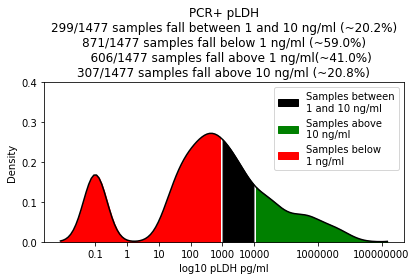

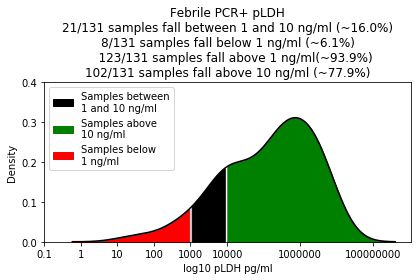

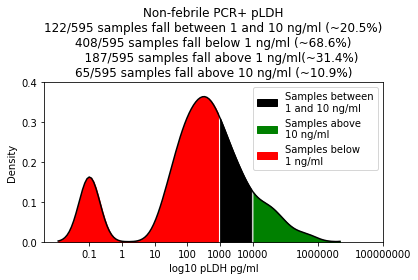

In [72]:
for test_df, pdf_title, plot_title in value_list:
    x = test_df['quansys_LDH_Pan_pg_ml'].values
    
    sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
    sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
    sub_samps = sub['sample_id'].values
    sub = len(sub)
    below = len(test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)])
    above = len(test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)])
    ten_above = len(test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(10000)])
    total = len(test_df)
    
    title = '''{p}\n{s}/{t} samples fall between 1 and 10 ng/ml (~{st}%)\n{b}/{t} samples fall below 1 ng/ml (~{bt}%)
    {a}/{t} samples fall above 1 ng/ml(~{at}%)\n{ta}/{t} samples fall above 10 ng/ml (~{tat}%)'''.format(p=pdf_title,
    t=total, s=sub, st=np.round(100*(sub/total), 1), b=below, bt=np.round(100*(below/total), 1), a=above,
    at=np.round(100*(above/total), 1), ta=ten_above, tat=np.round(100*(ten_above/total), 1))
    
    pp = PdfPages('C:/Users/lzoeckler/Desktop/{}.pdf'.format(plot_title))
    ax = sns.distplot(x, hist=False, color='k')
    ln = ax.lines[0]
    y = ln.get_ydata()
    x1 = ln.get_xdata()
    ax.fill_between(x1, 0, y, where=(np.log10(10000) > x1) & (x1 > np.log10(1000)), color='k', label='Samples between\n1 and 10 ng/ml')
    ax.fill_between(x1, 0, y, where=(np.log10(10000) < x1), color='g', label='Samples above\n10 ng/ml')
    ax.fill_between(x1, 0, y, where=(x1 < np.log10(1000)), color='r', label='Samples below\n1 ng/ml')
    ax.set_ylim(0, 0.4)
    ax.legend()
    ax.set_ylabel('Density')
    ax.set_xlabel('log10 pLDH pg/ml')
    plt.xticks([-1, 0, 1, 2, 3, 4, 6, 8], [0.1, 1, 10, 100, 1000, 10000, 1000000, 100000000])
    f = ax.get_figure()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    pp.savefig(f)
    plt.close()
    pp.close()

In [71]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
test_df = pos_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
18,-1.000000,2.184635,1.618884,NaN,1.889668,1.0,1 3201006 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
22,-1.000000,2.247581,-1.000000,NaN,2.338987,1.0,1 3421021 ()


In [20]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
sub_samps = sub['sample_id'].values
sub = len(sub)
sub

299

In [21]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
below = len(below)
below

871

In [22]:
above = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
above = len(above)
above

606

In [38]:
ten_above = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(10000)]
ten_above = len(ten_above)
ten_above

307

In [23]:
total = len(test_df)
total

1477

In [41]:
title = '''PCR+ pLDH\n{s}/{t} samples fall between 1 and 10 ng/ml (~{st}%)\n{b}/{t} samples fall below 1 ng/ml (~{bt}%)
{a}/{t} samples fall above 1 ng/ml(~{at}%)\n{ta}/{t} samples fall above 10 ng/ml (~{tat}%)'''.format(t=total, s=sub, st=np.round(100*(sub/total), 1), b=below,
                                                       bt=np.round(100*(below/total), 1), a=above, at=np.round(100*(above/total), 1), ta=ten_above, tat=np.round(100*(ten_above/total), 1))
title

'PCR+ pLDH\n299/1477 samples fall between 1 and 10 ng/ml (~20.2%)\n871/1477 samples fall below 1 ng/ml (~59.0%)\n606/1477 samples fall above 1 ng/ml(~41.0%)\n307/1477 samples fall above 10 ng/ml (~20.8%)'

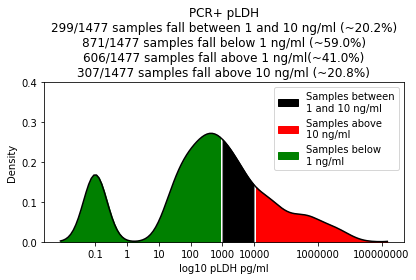

In [42]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(10000) > x1) & (x1 > np.log10(1000)), color='k', label='Samples between\n1 and 10 ng/ml')
ax.fill_between(x1, 0, y, where=(np.log10(10000) < x1), color='r', label='Samples above\n10 ng/ml')
ax.fill_between(x1, 0, y, where=(x1 < np.log10(1000)), color='g', label='Samples below\n1 ng/ml')
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6, 8], [0.1, 1, 10, 100, 1000, 10000, 1000000, 100000000])
f = ax.get_figure()
plt.title(title)
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [81]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
feb_df = pos_df.loc[pos_df['febrile'] == 1]
test_df = feb_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pan_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
86,3.804619,3.973994,1.132900,NaN,2.995130,1.0,10 3611019 ()
90,4.217487,4.630735,3.061622,NaN,1.709069,1.0,10 36341034 ()
115,3.591910,3.991607,3.975803,NaN,2.660987,1.0,11 2211003 ()
196,3.367522,3.155461,1.205204,NaN,3.514161,1.0,12 36341002 ()
233,4.217487,3.852183,-1.000000,NaN,3.479332,1.0,13 3201018 ()


In [82]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
sub_samps = sub['sample_id'].values
len(sub)

21

In [83]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

8

In [84]:
len(test_df)

131

In [85]:
21/131

0.16030534351145037

In [48]:
8/131

0.061068702290076333

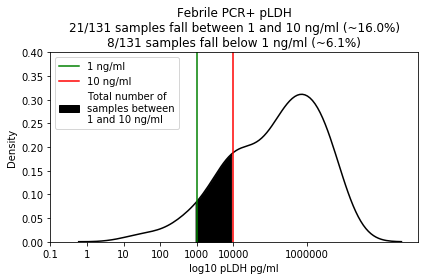

In [86]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/febrile_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(10000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 10 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(10000), color='r', label='10 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('Febrile PCR+ pLDH\n21/131 samples fall between 1 and 10 ng/ml (~16.0%)\n8/131 samples fall below 1 ng/ml (~6.1%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [87]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
non_feb_df = pos_df.loc[pos_df['febrile'] == 0]
test_df = non_feb_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pan_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
18,-1.000000,2.184635,1.618884,NaN,1.889668,1.0,1 3201006 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
22,-1.000000,2.247581,-1.000000,NaN,2.338987,1.0,1 3421021 ()


In [88]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
sub_samps = sub['sample_id'].values
len(sub)

122

In [89]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
below = below['sample_id'].values
len(below)

408

In [90]:
len(test_df)

595

In [91]:
122/595

0.20504201680672268

In [92]:
408/595

0.6857142857142857

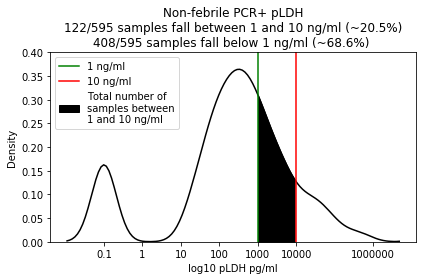

In [93]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/non_febrile_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(10000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 10 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(10000), color='r', label='10 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('Non-febrile PCR+ pLDH\n122/595 samples fall between 1 and 10 ng/ml (~20.5%)\n408/595 samples fall below 1 ng/ml (~68.6%) ')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()